In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from tqdm.auto import tqdm

from pyfield import tissue, util, PyField

np.seterr(all="ignore")

fc = 7e6
bw = fc * 0.8
fs = 100e6
rho = 1000
c = 1500
area = 35e-6 * 35e-6 * 4

# phantom paramters
ns = 10 * 1000**3  # scatterer density
# blood_att = 0.14 * 100 # 0.14 Np/cm which is about 1.25 dB/cm
# heart_att = 0.58 * 100 # 0.58 Np/cm which is about 5 dB/cm
blood_att = 0.14 * (5.6**1.21) / 8.6886 * 100  # in Np/m
myo_att = 0.52 * (5.6**1) / 8.6886 * 100  # in Np/m
dim = 0.01, 0.01, 0.03

# excitation parameters
path_to_excitation_file = 'd:/Projects/pyfield/examples/data_2x2_nonlinear_sim.npz'
data = np.load(path_to_excitation_file)

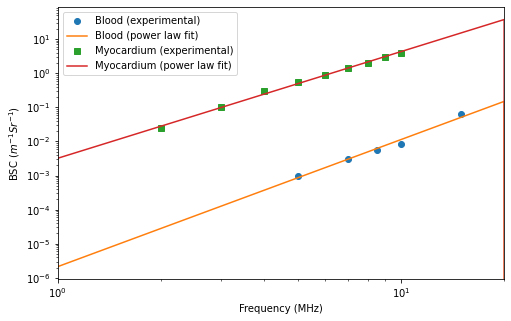

In [15]:
blood_bsc = tissue.bsc_human_blood_powerfit(freqs=np.arange(0, 20.5e6, 1e6), append=[[25e6], [0]])
myo_bsc = tissue.bsc_canine_myocardium_powerfit(freqs=np.arange(0, 20.5e6, 1e6), append=[[25e6], [0]])

plt.figure(figsize=(8, 5))
x, y = tissue.bsc_human_blood()
plt.loglog(x / 1e6, y, 'o', label='Blood (experimental)')
plt.loglog(blood_bsc[0] / 1e6, blood_bsc[1], label='Blood (power law fit)')
x, y = tissue.bsc_canine_myocardium()
plt.loglog(x / 1e6, y, 's', label='Myocardium (experimental)')
plt.loglog(myo_bsc[0] / 1e6, myo_bsc[1], label='Myocardium (power law fit)')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'BSC ($m^{-1} Sr^{-1}$)')
plt.xlim(1, 20);



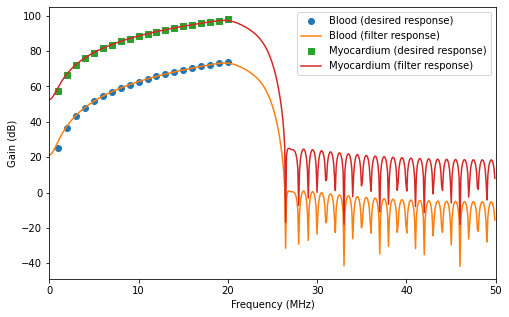

In [16]:
# blood_fir = tissue.bsc_to_fir(bf, bbsc, area, ns, fs)
# myo_fir = tissue.bsc_to_fir(mf, mbsc, area, ns, fs)
blood_fir = tissue.bsc_to_fir(*blood_bsc, area, ns, fs)
myo_fir = tissue.bsc_to_fir(*myo_bsc, area, ns, fs)

blood_w, blood_h = signal.freqz(blood_fir, fs=fs)
myo_w, myo_h = signal.freqz(myo_fir, fs=fs)

plt.figure(figsize=(8, 5))
y = 20 * np.log10(np.sqrt(blood_bsc[1][1:]) * 2 * np.pi / (area * np.sqrt(ns)))
plt.plot(blood_bsc[0][1:] / 1e6, y, 'o', label='Blood (desired response)')
plt.plot(blood_w  / 1e6, 20 * np.log10(np.abs(blood_h)), label='Blood (filter response)')
y = 20 * np.log10(np.sqrt(myo_bsc[1][1:]) * 2 * np.pi / (area * np.sqrt(ns)))
plt.plot(myo_bsc[0][1:] / 1e6, y, 's', label='Myocardium (desired response)')
plt.plot(myo_w  / 1e6, 20 * np.log10(np.abs(myo_h)), label='Myocardium (filter response)')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain (dB)')
plt.xlim(0, fs / 2 / 1e6);

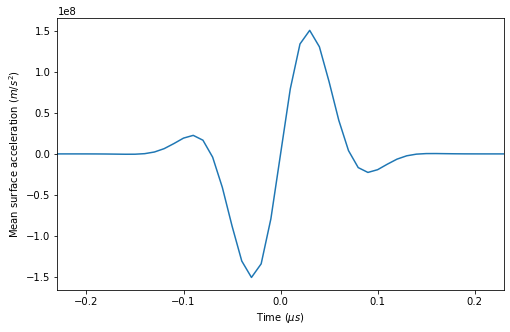

In [4]:
acc, acc_t = util.gausspulse(fc, bw / fc, fs, sym=True)
acc = acc * 190e6

plt.figure(figsize=(8, 5))
plt.plot(acc_t / 1e-6, acc)
plt.xlabel(r'Time ($\mu s$)')
plt.ylabel(r'Mean surface acceleration ($m / s^2$)')
plt.xlim(acc_t.min() / 1e-6, acc_t.max() / 1e-6);

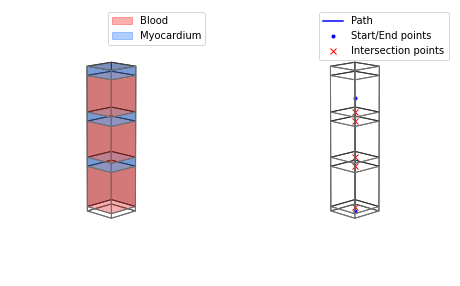

In [5]:
from matplotlib import patches

# phantom = tissue.cardiac_penetration_phantom(dim=(0.02, 0.02, 0.03), blood_att=blood_att, 
#                                              myo_att=myo_att, ns=ns)
phantom = tissue.cardiac_penetration_phantom(dim, blood_att=blood_att, 
                                             myo_att=myo_att, ns=ns)

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_axis_off()
ax1.azim = 45
ax1.elev = 10
cmap = {'none': '#ffffff00', 'blood': '#fc030350', 'myocardium': '#0362fc50'}
tissue.draw_phantom(phantom, colormap=cmap, ax=ax1)
util.set_axes_equal(ax1)
red = patches.Patch(color='#fc030350', label='Blood')
blue = patches.Patch(color='#0362fc50', label='Myocardium')
ax1.legend(handles=[red, blue])

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_axis_off()
ax2.azim = 45
ax2.elev = 10
tissue.draw_phantom(phantom, ax=ax2)
util.set_axes_equal(ax2)
tissue.draw_path_att((0, 0, 0), (0, 0, 0.025), phantom, ax=ax2)
ax2.legend()


In [16]:
def sum_with_padding(rfdata, t0s=None, fs=1, axis=-1):

    if len(rfdata) == 1:
        return rfdata[0], t0s[0]

    nsig = len(rfdata)
    shape = rfdata[0].shape
    ndim = len(shape)

    if t0s is None:
        t0s = [0] * nsig
    mint0 = min(t0s)

    frontpads = [int(np.ceil((t - mint0) * fs)) for t in t0s]
    maxlen = max([fpad + rf.shape[axis] for fpad, rf in zip(frontpads, rfdata)])
    backpads = [
        maxlen - (fpad + rf.shape[axis]) for fpad, rf in zip(frontpads, rfdata)
    ]

    newshape = list(shape)
    newshape[axis] = maxlen
    sumrf = np.zeros(newshape)

    for rf, fpad, bpad in zip(rfdata, frontpads, backpads):
        padwidth = [
            (0, 0),
        ] * ndim
        padwidth[axis] = (fpad, bpad)
        sumrf += np.pad(rf, padwidth, mode='constant')

    return sumrf, mint0


field = PyField()
field.field_init()

field.set_field('c', c)
field.set_field('fs', fs)
field.set_field('att', 0)
field.set_field('freq_att', 0)
field.set_field('att_f0', fc)
field.set_field('use_att', 1)

th = field.xdc_2d_array(2, 2, 35e-6, 35e-6, 10e-6, 10e-6, np.ones((2, 2)), 1, 1, [0, 0, 300])

p_layers = []

for key, props in phantom.items():
    
    if not isinstance(key, tuple):
        continue
    
    mat = props['material']
    scat = props['scat']
    
    if mat.lower() == 'none':
        continue
    elif mat.lower() == 'blood':
        fir = blood_fir
    elif mat.lower() == 'myocardium':
        fir = myo_fir
    
    p = np.zeros(1)
    for i, pt in enumerate(scat):
        
        sir, sir_t0 = field.calc_h(th, pt)
        sir = np.pad(sir * fs, (int(round(sir_t0 * fs)), 0), 'constant')

        att = tissue.calc_path_att([0, 0, 0], pt, phantom)

        p0 = rho * (att**2) * np.convolve(np.convolve(np.convolve(acc, sir) / fs, sir) / fs, fir) / fs 
        p, _ = sum_with_padding([p, p0], fs=fs)
#         break
    p_layers.append(p)
    
# p_total = np.sum(p_layers, axis=0)
p_total, _ = sum_with_padding(p_layers, fs=fs)

field.field_end()
# field.close()

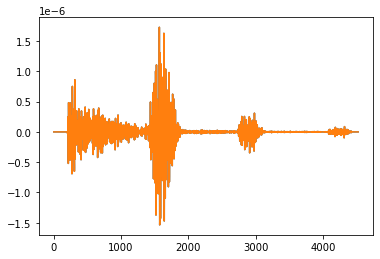

In [20]:
plt.plot(p_total)
plt.plot(p1)